# *O. polymorpha* as factory for small molecular weight biochemicals

The notebook explores the metabolic capacities of *O. polymorpha* to produce the small molecular weight biochemicals malate, acetone, and isoprene. For the analysis a modified genome scale model based on iUL909 [[Liebal et al., 2021](https://doi.org/10.1186/s12896-021-00675-w)] is used, in which reactions for acetone and isoprene production are added.

In [37]:
# Loading pandas, a library for data manipulation
import os
import xlrd
import pandas as pd
from datetime import date
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams['font.size'] = '14'
# plt.rcParams['font.family'] = 'Calibri'

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from iambcodes import countCinFormula, set_ObjGSMM, set_SubFlux, CreateTransReact

Today = date.today().strftime('%y%m%d')
SaveDir = os.path.join('..','data','MethanolBioconversion')
FigureType = 'svg'

In [38]:

def set_SubiOpol(model, Sub, Flux):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iOpol909
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    model.reactions.get_by_id('Ex_glc_D').lower_bound = 0
    model.reactions.get_by_id('Ex_{}'.format(Sub[0])).lower_bound = -Flux
    return model

In [39]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'Simulation'
GSMM_File = os.path.join('..','model', 'iOpol23.xml') # iUL909.xml for the original model
model = read_sbml_model(GSMM_File)
model_copy = model.copy()

#### Optional: Adding reactions
Applicable only if the original model w/o additional reactions is used. 

To activate set the `run` variable to `True`.

In [40]:
run = False # True if you want to adapt the original model
if run:
    # more realistic fluxes by forcing TCA activity
    # model.reactions.get_by_id('MDH').bounds = 0,0
    # model.reactions.get_by_id('AKGMALtm').bounds = 0,0

    ID = 'IPSYN'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Isoprene synthase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
        reaction.annotation = {'biocyc':'4.2.3.27-RXN' , 'brenda': '4.2.3.27'}
        IP = Metabolite(
            'isoprene[c]',
            formula = 'C5H8',
            name = 'Isoprene',
            charge = 0,
            compartment = 'c',
        )
        IP.annotation = {'biocyc':'CPD-9436', 'chebi':'35194', 'chemspider':'6309', 'inchi':' InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3', 'kegg.compound':'C16521', 'pubchem':'6557'}    
        IPP = model.metabolites.get_by_id('ipdp[c]')
        DP = model.metabolites.get_by_id('ppi[c]')
        reaction.add_metabolites({IPP:-1., IP:1., DP:1.})
        model.add_reactions([reaction])

        print(model.reactions.get_by_id(ID).id)
        print(model.reactions.get_by_id(ID).reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())
    # Isoprene transport reaction
    TransIso = CreateTransReact(model.metabolites.get_by_id('isoprene[c]'),'[]')
    model.add_reactions([TransIso])
    model.add_boundary(model.metabolites.get_by_id('isoprene[e]'), type="exchange", lb=0)

    # Acetone production
    # Acetoacetyl-CoA hydrolase
    # https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETYL-COA-HYDROLASE-RXN
    ID = 'AcAcCoAHYD'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Acetoacetyl-CoA Hydrolase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
        reaction.annotation = {'biocyc': 'ACETOACETYL-COA-HYDROLASE-RXN', 'brenda': '3.1.2.11'}
        model.add_reactions([reaction])
        model.reactions.get_by_id(ID).build_reaction_from_string('aacoa[c] + h2o[c] --> acac[c] + coa[c] + h[c]')

        print(reaction.id)
        print(reaction.reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())

    # Acetoacetate decarboxylase
    # https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETATE-DECARBOXYLASE-RXN
    ID = 'ACACDECARB'
    if ID not in model.reactions:
        reaction = Reaction(ID)
        reaction.name = 'Acetoacetate decarboxylase'
        reaction.lower_bound = 0.
        reaction.upper_bound = 1000.
        reaction.annotation = {'biocyc': 'ACETOACETATE-DECARBOXYLASE-RXN', 'brenda': '4.1.1.4'}
        ACONE = Metabolite(
            'acetone[c]',
            formula = 'C3H6O',
            name = 'Acetone',
            charge = 0,
            compartment = 'c',
        )
        ACONE.annotation = {'biocyc':'ACETONE', 'chebi':'15347', 'kegg.compound':'C00207', 'pubchem':'180'}    
        CO2 = model.metabolites.get_by_id('co2[c]')
        ACAC = model.metabolites.get_by_id('acac[c]')
        H = model.metabolites.get_by_id('h[c]')
        reaction.add_metabolites({ACAC:-1., H:-1., ACONE:1., CO2:1.})
        model.add_reactions([reaction])

        print(model.reactions.get_by_id(ID).id)
        print(model.reactions.get_by_id(ID).reaction)
        print(model.reactions.get_by_id(ID).check_mass_balance())

    # Acetone transport reaction
    TransAcetone = CreateTransReact(model.metabolites.get_by_id('acetone[c]'),'[]')
    model.add_reactions([TransAcetone])
    model.add_boundary(model.metabolites.get_by_id('acetone[e]'), type="exchange", lb=0)

    write_sbml_model(model, "iOpol23.xml")
else:
    print('Using the adapted model iOpol23.xml')

Using the adapted model iOpol23.xml


#### Reaction definitions
The dictionary contains reaction identifiers for whom the fluxes are stored.

In [41]:
RctFluxName = {
               # 'Ex_meoh':1,
               'HEX1':6, 
               'G6PDH2':6, 
               'PYK':3,
               'PC':4,
               'FUM':4,
               'MDH':4, 
               'MDHm':4,
               'MDHp':4,
               'PDHa1':3,
               'CSm':6, 
               'ICDOXSUCm':6,
               'AKGDH1':6,
               'SUCOASm':4,
               'SUCD2_u6m':4,
               'AKGMALtm':5, 
               'ICL':6, 
            #    'SUCDH_q6_m':4, 
            #    'MALSm':4, 
               # 'Ex_co2':1,
               # 'DM_mal_L[e]':4,
               }

[print(model.reactions.get_by_id(Rct)) for Rct in RctFluxName.keys()];

HEX1: atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c]
G6PDH2: g6p[c] + nadp[c] --> 6pgl[c] + h[c] + nadph[c]
PYK: adp[c] + h[c] + pep[c] --> atp[c] + pyr[c]
PC: atp[c] + hco3[c] + pyr[c] --> adp[c] + h[c] + oaa[c] + pi[c]
FUM: fum[c] + h2o[c] <=> mal_L[c]
MDH: mal_L[c] + nad[c] <=> h[c] + nadh[c] + oaa[c]
MDHm: mal_L[m] + nad[m] <=> h[m] + nadh[m] + oaa[m]
MDHp: mal_L[x] + nad[x] <=> h[x] + nadh[x] + oaa[x]
PDHa1: h[m] + pyr[m] + thmpp[m] --> 2_Hydroxyethyl_ThPP[m] + co2[m]
CSm: accoa[m] + h2o[m] + oaa[m] --> cit[m] + coa[m] + h[m]
ICDOXSUCm: icit[m] + nad[m] --> h[m] + nadh[m] + oxasucc[m]
AKGDH1: akg[m] + 5.0 h[m] + thmpp[m] --> 3_Carboxy_1_hydroxypropyl_ThPP[m] + co2[m]
SUCOASm: atp[m] + coa[m] + succ[m] <=> adp[m] + pi[m] + succoa[m]
SUCD2_u6m: q6[m] + succ[m] <=> fum[m] + q6h2[m]
AKGMALtm: akg[m] + mal_L[c] --> akg[c] + mal_L[m]
ICL: icit[c] --> glx[c] + succ[c]


#### Finding metabolites in model

In [42]:
# Returning the reaction details for reactions changed in the different scenarios
model.reactions.get_by_id('ICL')
# TCA-: PDHa1, PDHcm, ACLSm, AKGDH1+2, CITtam, CITtap, CSp+m
# TCA+: AKGDam
# Glx+Std: ICL

Reaction identifier,ICL
Name,Isocitrate lyase
Memory address,0x7fa64b0e3580
Stoichiometry,icit[c] --> glx[c] + succ[c] Isocitrate --> Glyoxylate + Succinate
GPR,OGAPODRAFT_17519
Lower bound,0.0
Upper bound,1000.0


In [43]:
# Searching for metabolite IDs
# CheckMetName = 'Acetone'
# [print('{}:\t{}:\t{}:\t{}\n'.format(MetID.name, MetID.id, MetID.formula, MetID.annotation)) for MetID in model.metabolites.query(CheckMetName, 'name')];

CheckMetID = 'f6p[c]'
[print(f'{myRct.id}: {myRct.reaction}') for myRct in model.metabolites.get_by_id(CheckMetID).reactions];

PGI: g6p[c] <=> f6p[c]
GF6PTA: f6p[c] + gln_L[c] --> gam6p[c] + glu_L[c]
G6PI3: g6p_B[c] <=> f6p[c]
SBTPD: nad[c] + sbt6p[c] <=> f6p[c] + h[c] + nadh[c]
G6PDA: gam6p[c] + h2o[c] --> f6p[c] + nh4[c]
MAN6PI: man6p[c] <=> f6p[c]
ALS6PE: als6p_D[c] <=> f6p[c]
PFK26: atp[c] + f6p[c] --> adp[c] + f26bp[c] + h[c]
TALA: g3p[c] + s7p[c] <=> e4p[c] + f6p[c]
HEX7: atp[c] + fru[c] --> adp[c] + f6p[c] + h[c]
FBP: fdp[c] + h2o[c] --> f6p[c] + pi[c]
TKT2: e4p[c] + xu5p_D[c] <=> f6p[c] + g3p[c]
PFK: atp[c] + f6p[c] --> adp[c] + fdp[c] + h[c]
FBP26: f26bp[c] + h2o[c] --> f6p[c] + pi[c]


### Production envelope Growth-rate versus Yield
The following cell determines the production envelope of the production of malate, acetate, and isoprene with different growth rates.

In [44]:
# required minimum growth rate
bio = np.linspace(.001,.12,5)
Substrate = 'meoh'
flux=10
Product = ['mal_L[e]','acetone[e]','isoprene[e]']
PCol = {'mal_L[e]':'m', 'acetone[e]':'b', 'isoprene[e]':'g'}
PMark = {'mal_L[e]':'x', 'acetone[e]':'o', 'isoprene[e]':'d'}
YieldProd = dict()

for myProd in Product:
    Cnum = countCinFormula(model.metabolites.get_by_id(myProd).formula)
    Yield = list()
    for bioi in bio:
        with model as md:
            md.reactions.get_by_id('BIOMASS').lower_bound = bioi
            md = set_ObjGSMM(md, myProd)
            md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
            sol = md.optimize()
            Yield.append(sol.fluxes['DM_{}'.format(myProd)]/flux) # *Cnum in the nominator for yield in Cmol/Cmol
    YieldProd[myProd] = {'Yield':Yield, 'growth':list(bio), 'color':PCol[myProd], 'marker': PMark[myProd]}


Figure saved as ../data/MethanolBioconversion/231128_ProdYields-VS-Growth.svg


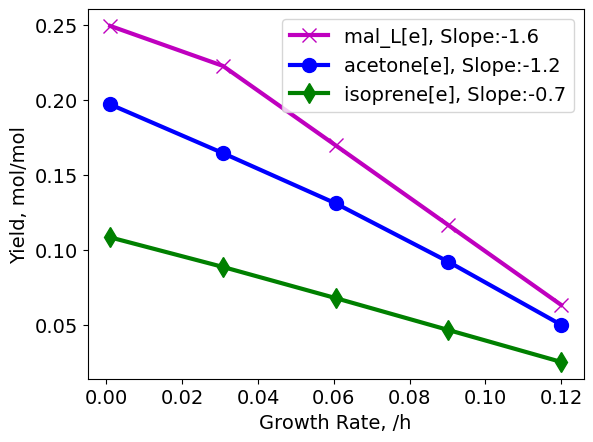

In [45]:
FigureName = 'ProdYields-VS-Growth'
for Target in YieldProd.keys():
    m,n = np.polyfit(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 1)
    plt.plot(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 
                c = PCol[Target], 
                marker = PMark[Target], markersize = 10, linewidth = 3,
                label = f'{Target}, Slope:{round(m,1)}')
plt.xlabel('Growth Rate, /h')
plt.ylabel('Yield, mol/mol')
plt.legend()
PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
plt.savefig(PlotName, dpi=300, bbox_inches='tight')
print(f'Figure saved as {PlotName}')
# plt.title('PYC Active') #+AKG/Mal mTran
plt.show()

## Malate Yield for Different Pathways

Scenarios analysed:
- Blocked TCA: deactivation of pyruvate dehydrogenase (PDH) and mitochondrial acetolactate synthase (ACLSm)
- Forced TCA: minimum reaction flux through alpha-ketoglutarate dehydrogenase (AKGDam)
- Forced standard Glyoxylate shunt: minimum reaction flux through isocitrate lyase (ICL)
- Forced impaired Glyoxylate shunt: minimum reaction flux through isocitrate lyase (ICL), deactivated malate dehydrogenase (MDHm)

### General simulation setup
- Methanol is used as sole substrate with uptake rate of 10 mmol/gDW/h.
- The objective function is set to malate.
- All results are stored in a csv-file with the name `[Date]_MalPathFlux.csv`

In [46]:
model_mal = model.copy()

# setting dictionary to store all flux results
FluxAll = dict()

def Model_Unconstrained(model, target):
    '''
    Setting the model to be unconstrained. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    return model


def Model_BlockedTCA(model, target):
    '''
    Setting the TCA cycle to be blocked. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)

    model.reactions.get_by_id('PDHa1').upper_bound = 0
    model.reactions.get_by_id('PDHcm').upper_bound = 0
    model.reactions.get_by_id('ACLSm').upper_bound = 0
    model.reactions.get_by_id('AKGDH1').upper_bound = 0
    model.reactions.get_by_id('AKGDH2').upper_bound = 0
    model.reactions.get_by_id('CITtam').upper_bound = 0
    model.reactions.get_by_id('CITtap').upper_bound = 0
    model.reactions.get_by_id('CSp').upper_bound = 0
    model.reactions.get_by_id('CSm').upper_bound = 0
    
    return model

def Model_ForceTCA(model, target):
    '''
    Setting the TCA cycle to be active. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    model.reactions.get_by_id('AKGDam').lower_bound = 7.8
    return model

def Model_ForceStdGlx(model, target):
    '''
    Setting the Glx cycle to be active. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)

    model.reactions.get_by_id('ICL').lower_bound = 10
    return model

def Model_ForceImpGlx(model, target):
    '''
    Setting the Glx cycle to be active but with mutations in MDHm. With target as the desired product, the model will be optimized for production.
    '''
    # optimizing for production
    set_ObjGSMM(model, target)
    set_SubFlux(model, ['meoh'], 'Ex_glc_D', 10)
    model.reactions.get_by_id('ICL').lower_bound = 10
    model.reactions.get_by_id('MDHm').bounds = -10, 2.85
    return model


### Unconstrained optimal product flux

In [47]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_Unconstrained(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['UnconstrainedRef'] = FluxScenario

print('')
[print(f'{model_mal.reactions.get_by_id(Rct).id} \t {model_mal.reactions.get_by_id(Rct).reaction} \t {round(sol[Rct],2)}') for Rct in RctFluxName.keys()];

2.499999999999998
0.24999999999999978
Objective
1.0 DM_mal_L[e] = 2.4999999999999987

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2  7.5         0   0.00%

Secretion
---------
Metabolite    Reaction  Flux  C-Number  C-Flux
  mal_L[e] DM_mal_L[e]  -2.5         4 100.00%
      h[e]        Ex_h    -5         0   0.00%
    h2o[e]      Ex_h2o -12.5         0   0.00%

1.9792307692307594
0.19792307692307592
Objective
1.0 DM_acetone[e] = 1.9792307692307631

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 7.083         0   0.00%

Secretion
---------
Metabolite      Reaction   Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -1.979         3 59.38%
    co2[e]        Ex_co2 -4.062         1 40.62%
    h2o[e]        Ex_h2o -14.06         0  0.00%

1.08933333333333
0.108933333333333
Objective
1.0 DM_isoprene[e] = 1.0893333333333288

Uptake
------
Metaboli

### Blocked TCA scenario

In [48]:

with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_BlockedTCA(md, target)

        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['BlockedTCA'] = FluxScenario

2.4999999999999933
0.24999999999999933
Objective
1.0 DM_mal_L[e] = 2.4999999999999987

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2  7.5         0   0.00%

Secretion
---------
Metabolite    Reaction  Flux  C-Number  C-Flux
  mal_L[e] DM_mal_L[e]  -2.5         4 100.00%
      h[e]        Ex_h    -5         0   0.00%
    h2o[e]      Ex_h2o -12.5         0   0.00%

1.92974999999999
0.192974999999999
Objective
1.0 DM_acetone[e] = 1.9297499999999936

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 7.281         0   0.00%

Secretion
---------
Metabolite      Reaction   Flux  C-Number C-Flux
acetone[e] DM_acetone[e]  -1.93         3 57.89%
    co2[e]        Ex_co2 -4.211         1 42.11%
    h2o[e]        Ex_h2o -14.21         0  0.00%

1.0398181818181824
0.10398181818181824
Objective
1.0 DM_isoprene[e] = 1.0398181818181784

Uptake
------
Metabol

### Forced TCA scenario

In [49]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceTCA(md, target)

        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedTCA'] = FluxScenario

0.010545454545456035
0.0010545454545456035
Objective
1.0 DM_mal_L[e] = 0.010545454545559142

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.97         0   0.00%

Secretion
---------
Metabolite    Reaction     Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.01055         4  0.42%
    co2[e]      Ex_co2   -9.958         1 99.58%
      h[e]        Ex_h -0.02109         0  0.00%
    h2o[e]      Ex_h2o   -19.97         0  0.00%

0.007073170731641234
0.0007073170731641234
Objective
1.0 DM_acetone[e] = 0.007073170731631028

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.97         0   0.00%

Secretion
---------
Metabolite      Reaction      Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.007073         3  0.21%
    co2[e]        Ex_co2    -9.979         1 99.79%
    h2o[e]        Ex_h2o    -19.98         0  0.00%

0.003892617449644574
0.

### Forced standard Glyoxylate shunt

In [50]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceStdGlx(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedStdGlx'] = FluxScenario

0.23966666666671216
0.023966666666671216
Objective
1.0 DM_mal_L[e] = 0.23966666666667155

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.28         0   0.00%

Secretion
---------
Metabolite    Reaction    Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.2397         4  9.59%
    co2[e]      Ex_co2  -9.041         1 90.41%
      h[e]        Ex_h -0.4793         0  0.00%
    h2o[e]      Ex_h2o  -19.28         0  0.00%

0.1563043478260904
0.01563043478260904
Objective
1.0 DM_acetone[e] = 0.15630434782609032

Uptake
------
Metabolite Reaction  Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh    10         1 100.00%
     o2[e]    Ex_o2 14.37         0   0.00%

Secretion
---------
Metabolite      Reaction    Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.1563         3  4.69%
    co2[e]        Ex_co2  -9.531         1 95.31%
    h2o[e]        Ex_h2o  -19.53         0  0.00%

0.08768292682933605
0.008768292682933606
Obj

### Forced impaired Glyoxylate shunt

In [51]:
with model_mal as md:
    FluxScenario = dict()
    for target in Product:
        # optimizing for production
        md = Model_ForceImpGlx(md, target)
        sol = md.optimize()
        print(sol.fluxes[f'DM_{target}'])
        # yield of malate from methanol
        print(-sol.fluxes[f'DM_{target}']/sol.fluxes['Ex_meoh'])
        # print exchange fluxes
        print(md.summary())
        FluxScenario[target] = {md.reactions.get_by_id(Rct).id: round(sol[Rct],2) for Rct in sol[np.abs(sol.fluxes)>1e-2].keys()}
    FluxAll['ForcedImpGlx'] = FluxScenario
# print('')
# [print(f'{model_mal.reactions.get_by_id(Rct).id} \t {model_mal.reactions.get_by_id(Rct).reaction} \t {round(sol[Rct],2)}') for Rct in RctFluxName.keys()];

0.0014285714285170315
0.00014285714285170315
Objective
1.0 DM_mal_L[e] = 0.001428571428474534

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2   15         0   0.00%

Secretion
---------
Metabolite    Reaction      Flux  C-Number C-Flux
  mal_L[e] DM_mal_L[e] -0.001429         4  0.06%
    co2[e]      Ex_co2    -9.994         1 99.94%
      h[e]        Ex_h -0.002857         0  0.00%
    h2o[e]      Ex_h2o       -20         0  0.00%

0.0009356725145846641
9.35672514584664e-05
Objective
1.0 DM_acetone[e] = 0.0009356725146136245

Uptake
------
Metabolite Reaction Flux  C-Number  C-Flux
   meoh[e]  Ex_meoh   10         1 100.00%
     o2[e]    Ex_o2   15         0   0.00%

Secretion
---------
Metabolite      Reaction       Flux  C-Number C-Flux
acetone[e] DM_acetone[e] -0.0009357         3  0.03%
    co2[e]        Ex_co2     -9.997         1 99.97%
    h2o[e]        Ex_h2o        -20         0  0.00%

0.000526315789462

### File export of data

In [63]:
# export fluxes from transposed myResults to xlsx file with multiple sheets
File = os.path.join(SaveDir, f'{Today}_ScenarioPathFlux.xlsx')
myResults = pd.DataFrame(FluxAll).transpose()
with pd.ExcelWriter(File) as writer:
    for target in list(myResults.columns):
        print(target)
        # print(myResults.to_dict()[target])
        pd.DataFrame(myResults[target].to_dict()).to_excel(writer, sheet_name=target[:-3])
        print('') 
        # print file location
print(f'Flux file saved in {File}')


mal_L[e]

acetone[e]

isoprene[e]

Flux file saved in ../data/MethanolBioconversion/231128_ScenarioPathFlux.xlsx


### PCA of scenario fluxes
A PCA of the fluxes of the scenarios shows how different the solutions are.

In [67]:
# if you want to load an existing file set the file name and set LoadExisting to True
File = os.path.join(SaveDir, 'ScenarioPathFlux_published.xlsx')
LoadExisting = True

if LoadExisting == True:
    # Define the file path
    file_path = File

    # Load the Excel file
    Data = pd.read_excel(file_path, sheet_name=None)

    # Create an empty dataframe
    myResults = pd.DataFrame()

    # Iterate over each sheet in the loaded Excel file
    for sheet_name, data in Data.items():
        # Get the non-index columns as a single list
        columns = data.columns[1:]
        # Create a dictionary to store the values for each column
        column_dict = {}
        # Iterate over each column
        for column in columns:
            # Get the values for the current column
            values = data[column].values
            # Create a dictionary with the row index as the key and the value as the value
            values_dict = {row: value for row, value in zip(data.iloc[:, 0].values.flatten(), values)}
            # Add the column dictionary to the main dictionary
            column_dict[column] = values_dict
        # Create a dataframe with the column dictionary as the data
        column_df = pd.DataFrame({sheet_name:column_dict}) #{sheet_name:column_dict}
        # Set the row index of column_df to the values in columns
        column_df.set_index(columns.sort_values(), inplace=True) #
        # Add the column dataframe to the main dataframe
        myResults = pd.concat([myResults, column_df], axis=1)
    print(myResults)

                                                              mal_L  \
BlockedTCA        {'NADH2_u6mh': 5.0, 'PTE183x': nan, 'PIt2p': n...   
ForcedImpGlx      {'NADH2_u6mh': 9.99, 'PTE183x': nan, 'PIt2p': ...   
ForcedStdGlx      {'NADH2_u6mh': 8.56, 'PTE183x': nan, 'PIt2p': ...   
ForcedTCA         {'NADH2_u6mh': 12.14, 'PTE183x': nan, 'PIt2p':...   
UnconstrainedRef  {'NADH2_u6mh': 4.17, 'PTE183x': 1.29, 'PIt2p':...   

                                                            acetone  \
BlockedTCA        {'NADH2_u6mh': 4.56, 'ASNt2m': 1.23, 'FORtrn':...   
ForcedImpGlx      {'NADH2_u6mh': 9.99, 'ASNt2m': nan, 'FORtrn': ...   
ForcedStdGlx      {'NADH2_u6mh': 8.75, 'ASNt2m': nan, 'FORtrn': ...   
ForcedTCA         {'NADH2_u6mh': 12.14, 'ASNt2m': nan, 'FORtrn':...   
UnconstrainedRef  {'NADH2_u6mh': 4.17, 'ASNt2m': 0.94, 'FORtrn':...   

                                                           isoprene  
BlockedTCA        {'NADH2_u6mh': 5.44, 'CYOR_u6m': 5.44, 'ACACT1...  
Forced

/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future

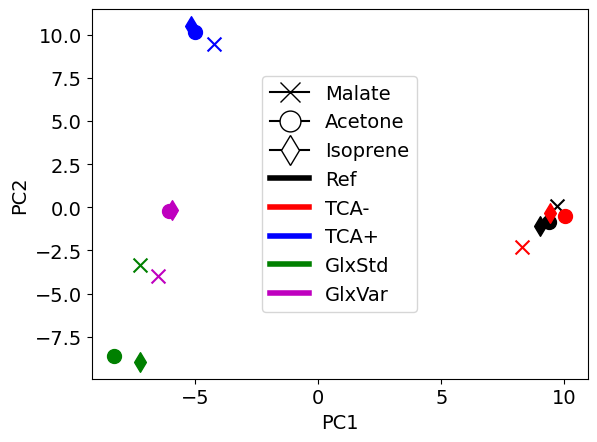

Figure saved as ../data/MethanolBioconversion/231128_PCA-Flux-All.svg


In [68]:
IndxList = list()
for target in myResults.columns:
    IndxList.append(pd.DataFrame(myResults[target].to_dict()).index)
# find intersection of all indices in IndxList
Indx = list(set.intersection(*map(set, IndxList)))


# Constructing a PCA plot of the fluxes in the dataframe myResults for all components but only with the index values in Indx
myMark = {'mal_L[e]':'x', 'acetone[e]':'o', 'isoprene[e]':'d'}
# Dictionary with labels for the different scenarios
if LoadExisting == True:
    myLabel = {'BlockedTCA':'TCA-', 'ForcedImpGlx':'GlxVar', 'ForcedStdGlx':'GlxStd', 'ForcedTCA':'TCA+', 'UnconstrainedRef':'Ref'}
else: 
    myLabel = {'UnconstrainedRef':'Ref', 'BlockedTCA':'TCA-', 'ForcedTCA':'TCA+', 'ForcedStdGlx':'GlxStd', 'ForcedImpGlx':'GlxVar'}
myLabelColor = {'Ref':'k', 'TCA-':'r', 'TCA+':'b', 'GlxStd':'g', 'GlxVar':'m'}
AllDatSeq = list(product(myMark.keys(), myLabel.values()))
PlotLabel = [[myMark[element[0]],myLabelColor[element[1]]] for element in AllDatSeq]
PrintLabel = [f'{element[0]}-{element[1]}' for element in AllDatSeq]

x = list()
for target in list(myResults.columns):
    # Replacing NaN values with 0
    myDat = pd.DataFrame(myResults[target].to_dict()).fillna(0).loc[Indx]

    # Standardizing the features
    x.append(StandardScaler().fit_transform(myDat.T))
x = np.array(x).reshape(-1, len(Indx)) # 134 is the number of reactions in the model 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'], index = PrintLabel)
# adding columns for target marker type and pathway color
principalDf['Target'] = [mylist[0] for mylist in PlotLabel]
principalDf['Path'] = [mylist[1] for mylist in PlotLabel]

# Plotting the PCA
# plt.figure(figsize=(10,10))
plt.xlabel('PC1')
plt.ylabel('PC2')
for idx, row in principalDf.iterrows():
    plt.scatter(row['PC1'], row['PC2'], s=100, marker=row['Target'], c=row['Path'], label=idx)

# adding manual legend for target marker and pathway color
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = [Line2D([0], [0], marker='x', color='k', label='Malate', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], marker='o', color='k', label='Acetone', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], marker='d', color='k', label='Isoprene', markerfacecolor='w', markersize=15),
                   Line2D([0], [0], color='k', lw=4, label='Ref'),
                   Line2D([0], [0], color='r', lw=4, label='TCA-'),
                   Line2D([0], [0], color='b', lw=4, label='TCA+'),
                   Line2D([0], [0], color='g', lw=4, label='GlxStd'),
                   Line2D([0], [0], color='m', lw=4, label='GlxVar')]
# plt.legend(handles = legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(handles = legend_elements, loc='center')


# saving figure
FigureName = 'PCA-Flux-All'
PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
plt.savefig(PlotName, dpi=300, bbox_inches='tight')
plt.show()
print(f'Figure saved as {PlotName}')

### Flux correlations to target production

For the five different scenarios the fluxes for each reaction are correlated with the target flux.

mal_L
Top 5 reactions:
aconitase
succinate dehydrogenase (ubiquinone-6), mitochondrial
fumarase, mitochondrial
L-serine deaminase
methylenetetrahydrofolate dehydrogenase (NADP)



/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_7936/829677323.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  RctNames = CorrMat[np.where(np.logical_and(np.abs(CorrMat)>LimLow, np.abs(CorrMat)<LimHigh))[0]].index
/tmp/ipykernel_7936/829677323.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  RctValues = C


acetone
Top 5 reactions:
L-asparagine transport, mitochondrial
asparagine mitochondrial transport via proton transport
succinate dehydrogenase (ubiquinone-6), mitochondrial
succinate dehydrogenase
aconitase


isoprene
Top 5 reactions:
Hydroxymethylglutaryl-CoA reversible mitochondrial transport
CoA transporter (mitochondrial), irreversible
Hydroxymethylglutaryl CoA synthase, mitochondrial
acetyl-CoA C-acetyltransferase, mitochondrial
succinate dehydrogenase (ubiquinone-6), mitochondrial



/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_7936/829677323.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  RctNames = CorrMat[np.where(np.logical_and(np.abs(CorrMat)>LimLow, np.abs(CorrMat)<LimHigh))[0]].index
/tmp/ipykernel_7936/829677323.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  RctValues = C

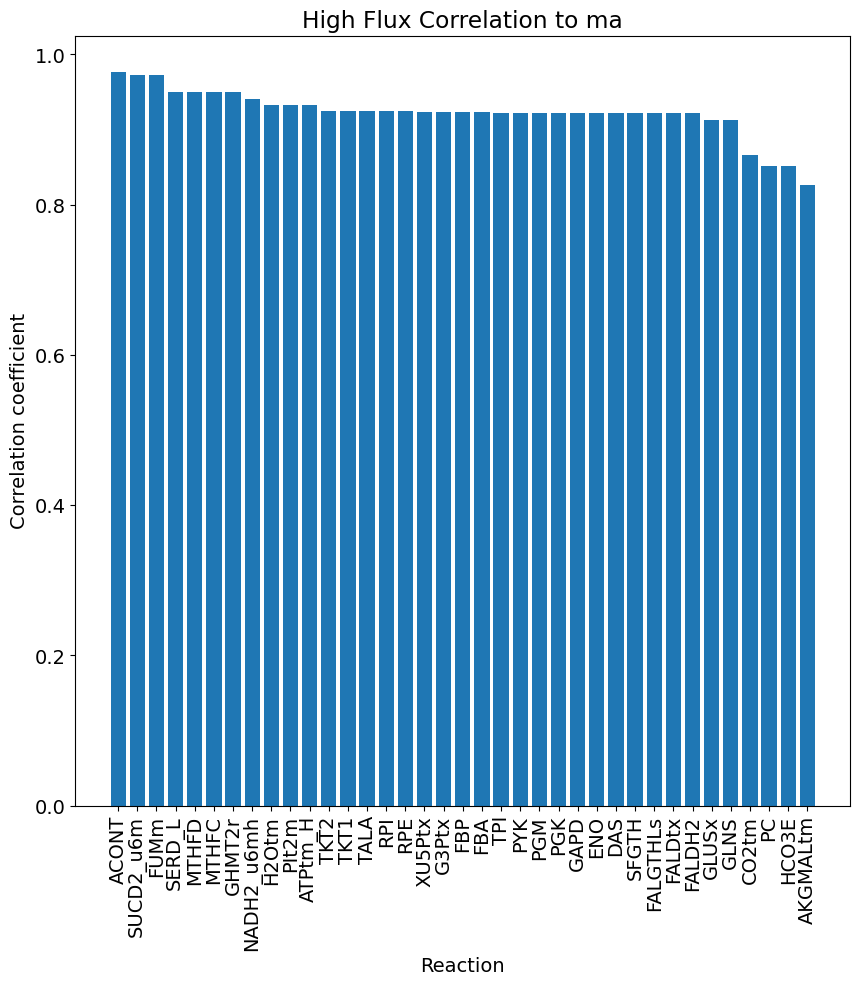

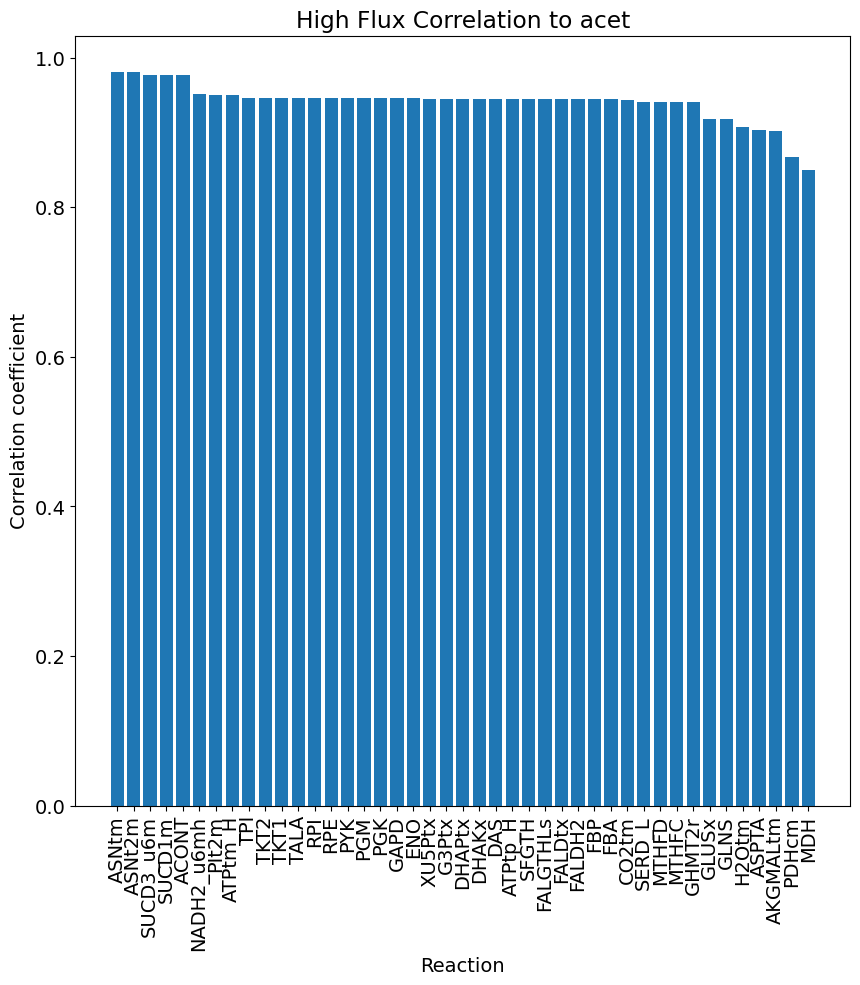

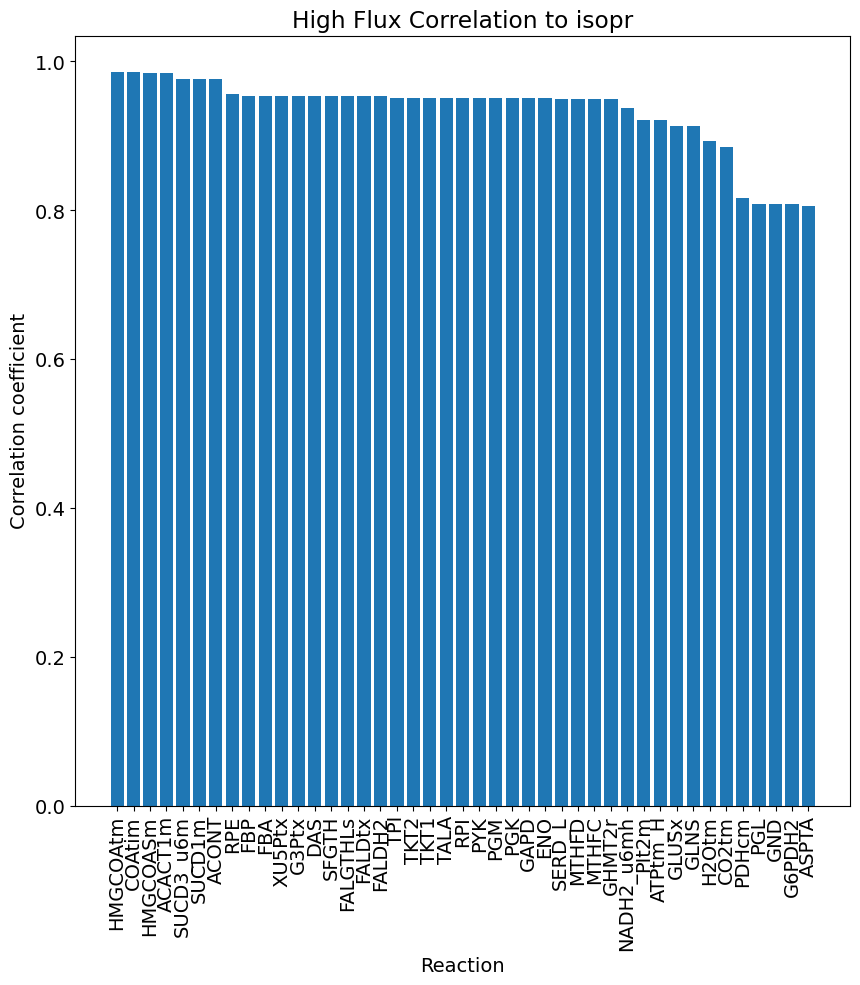

In [69]:
RctTarget_dict = dict()

for target in list(myResults.columns):
    print(target)
    FluxColumns = pd.DataFrame(myResults[target].to_dict()).fillna(0).transpose()

    # calculate the correlation matrix of FluxColumns with respect to the malate flux Y
    if LoadExisting == True:
        CorrMat = FluxColumns.corrwith(FluxColumns[f'DM_{target}[e]'])
    else:
        CorrMat = FluxColumns.corrwith(FluxColumns[f'DM_{target}'])

    # generate a bar plot of the absolute correlation coefficients with values in the range [LimLow,LimHigh] and with the name of the reaction on x-axis
    plt.figure(figsize=(10,10))
    LimLow = 0.8
    LimHigh = 0.99
    # names of reactions within the correlation range
    RctNames = CorrMat[np.where(np.logical_and(np.abs(CorrMat)>LimLow, np.abs(CorrMat)<LimHigh))[0]].index
    # values of reactions within the correlation range
    RctValues = CorrMat[np.where(np.logical_and(np.abs(CorrMat)>LimLow, np.abs(CorrMat)<LimHigh))[0]].values
    # print original values and names
    RctTarget_dict[target] = {RctName: round(RctValue,2) for RctName, RctValue in zip(RctNames, RctValues)}
    # sort values and names
    RctNames = [x for _,x in sorted(zip(np.abs(RctValues),RctNames), reverse=True)]
    RctValues = sorted(np.abs(RctValues), reverse=True)
    # print the reaction names for the first five reactions
    print('Top 5 reactions:')
    [print(model.reactions.get_by_id(Rct).name) for Rct in RctNames[:5]]
    print('')

    plt.bar(RctNames, RctValues)#, color='k')
    plt.xticks(rotation=90)
    plt.xlabel('Reaction')
    plt.ylabel('Correlation coefficient')
    plt.title(f'High Flux Correlation to {target[:-3]}')
    # saving figure
    # FigureName = f'CorrFlux-{target[:-3]}'
    # PlotName = os.path.join(SaveDir, f'{Today}_{FigureName}.{FigureType}')
    # plt.savefig(PlotName, dpi=300, bbox_inches='tight')
    # print(f'Figure saved as {PlotName}')
    print('')
plt.show()

# saving correlation coefficients to xlsx file
File = os.path.join(SaveDir, f'{Today}_CorrFlux.xlsx')
with pd.ExcelWriter(File) as writer:
    pd.DataFrame(RctTarget_dict).to_excel(writer, sheet_name='CorrFlux')
    # print file location
print(f'Correlation file saved in {File}')
# pd.DataFrame(RctTarget_dict)